### Bonus: A Shallow Dive into Deep Learning

To put what I've learned in the Deep Learning Unit into practice, I will attempt to improve upon my Gradient Boosting model from the Machine Learning notebook.

In [1]:
# Import pandas for reading in the data
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sys

The initial setup is the same as before.

In [2]:
top_stocks = pd.read_hdf('../data/clean/computed_stocks.h5', key='top_stocks')

top_stocks.reset_index(inplace=True)
top_stocks.drop_duplicates(['symbol', 'date'], inplace=True)
top_stocks.set_index('date', inplace=True)

In [3]:
top_stocks.index = pd.to_datetime(top_stocks.index)

In [4]:
# top_stocks = pd.concat([top_stocks['2007'],
#                         top_stocks['2009':'2010'],
#                         top_stocks['2012'],
#                         top_stocks['2014':]])

In [5]:
import json
COLUMNS = []

with open('../models/columns.json') as column_file:
    COLUMNS = json.load(column_file)
#     COLUMNS = list(filter(lambda x: 'market' not in x, COLUMNS))

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, QuantileTransformer
from imblearn.under_sampling import RandomUnderSampler

X = top_stocks[COLUMNS]
y = top_stocks[['buy_signal']]
    
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

Using Theano backend.


In [7]:
sm = RandomUnderSampler()
X_train, y_train = sm.fit_resample(X_train, y_train)

To create the neural network model, I will use the Keras library, which is built upon TensorFlow. Keras requires that the result column is in a categorical format, but it provides the function "to_categorical" for this purpose.

The data must first be scaled to improve accuracy. The test data is not scaled independently, but according to the fit of the train data. After testing both the StandardScaler and the MinMaxScaler, the StandardScaler performs better and converges in fewer epochs.

In [8]:
from pickle import dump
from sklearn.preprocessing import MinMaxScaler, QuantileTransformer

scaler = QuantileTransformer(output_distribution='normal')
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

dump(scaler, open('../models/scaler_market.pkl', 'wb'))

In [9]:
from keras.utils import to_categorical

y_train_cat = to_categorical(y_train) 
y_test_cat = to_categorical(y_test)

To build the neural network, I used a simple sequential model with just one hidden layer containing 100 nodes. I tested many different configurations, but adding layers and nodes did not improve the final test accuracy score. The Rectified Linear Unit or "RELU" activation function performs better than sigmoid activation functions like "tanh". The output layer must have 2 nodes, representing a win or a loss. The "softmax" activation function is also necessary for binary classification, as it converts the outputs to probabilities and ensures that they add up to 1.

In [10]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout

model = Sequential()

model.add(Dense(200, activation='relu', input_dim=X_train_scaled.shape[1]))
model.add(Dense(100, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(2, activation='softmax'))

The model was compiled with the "adam" optimizer. I also chose the "categorical_crossentropy" loss function, a good default for classification. 

In [11]:
from keras.metrics import accuracy
from keras.optimizers import Adam

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

When fitting the model, I used two callbacks provided by Keras. The EarlyStopping callback stops when the validation loss function does not improve after five epochs. The ModelCheckpoint callback saves the model with the best validation accuracy score. I experimented with splitting the training data to create an additional validation set, but setting the test data as the validation set optimizes for test set accuracy.

In [12]:
from keras.callbacks.callbacks import EarlyStopping
from keras.callbacks.callbacks import ModelCheckpoint

es = EarlyStopping(monitor='val_loss', patience=3)
mc = ModelCheckpoint('../models/daily_market.h5', monitor='val_loss', save_best_only=True)

history = model.fit(X_train_scaled, y_train_cat, 
          epochs=20, 
          callbacks= [es, mc], 
          batch_size=128,
          validation_data=(X_test_scaled, y_test_cat), 
          shuffle=True)

Train on 1169322 samples, validate on 302045 samples
Epoch 1/20
1169322/1169322 [==============================] - 23s 20us/step - loss: 0.6392 - accuracy: 0.6146 - val_loss: 0.5932 - val_accuracy: 0.6740
Epoch 2/20
1169322/1169322 [==============================] - 24s 21us/step - loss: 0.5801 - accuracy: 0.6861 - val_loss: 0.5717 - val_accuracy: 0.6942
Epoch 3/20
1169322/1169322 [==============================] - 24s 20us/step - loss: 0.5660 - accuracy: 0.6983 - val_loss: 0.5638 - val_accuracy: 0.6996
Epoch 4/20
1169322/1169322 [==============================] - 24s 20us/step - loss: 0.5590 - accuracy: 0.7034 - val_loss: 0.5593 - val_accuracy: 0.7036
Epoch 5/20
1169322/1169322 [==============================] - 24s 21us/step - loss: 0.5548 - accuracy: 0.7064 - val_loss: 0.5527 - val_accuracy: 0.7078
Epoch 6/20
1169322/1169322 [==============================] - 24s 21us/step - loss: 0.5515 - accuracy: 0.7096 - val_loss: 0.5558 - val_accuracy: 0.7055
Epoch 7/20
1169322/1169322 [=======

An evaluation of the best model shows a test accuracy of 66.5%. This outperforms any of my previous Machine Learning models, even after hyperparameter tuning. 

In [13]:
from keras.models import load_model

best_model = load_model('../models/daily_market.h5')
train_loss, train_accuracy = best_model.evaluate(X_train_scaled, y_train_cat)
test_loss, test_accuracy = best_model.evaluate(X_test_scaled, y_test_cat)
print(train_loss, test_loss)
print(train_accuracy, test_accuracy)

302045/302045 [==============================] - 2s 7us/step
0.5320956148279762 0.5439568838207621
0.724298357963562 0.7158833742141724


In [14]:
predictions = pd.DataFrame(zip(best_model.predict(X_test_scaled)[:, 1], y_test_cat[:, 1]),
                           columns=['prediction', 'signal'])

In [15]:
predictions['prediction_correct'] = ((predictions.prediction >= 0.5) & (predictions.signal == 1)) | \
                                    ((predictions.prediction < 0.5) & (predictions.signal == 0))

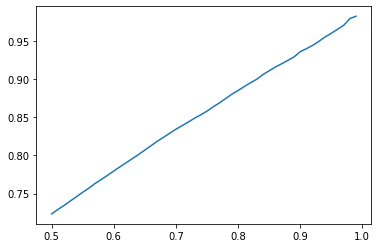

In [16]:
def buy_signal_curve():
    curve = []
    odds = np.arange(.5, 1.0, .01)
    for o in odds:
        total = len(predictions[predictions.prediction > o])
        correct = len(predictions[(predictions.prediction > o) & (predictions.prediction_correct == True)])
        if total == 0:
            curve.append(1)
        else:
            curve.append(correct / total)
    plt.plot(odds, curve)
    
buy_signal_curve()

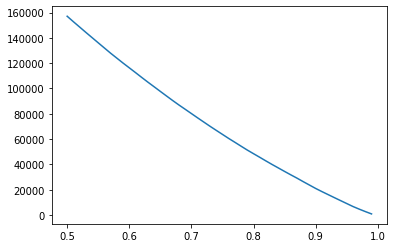

In [17]:
def buy_signal_curve_2():
    curve = []
    odds = np.arange(.5, 1.0, .01)
    for o in odds:
        total = len(predictions[predictions.prediction > o])
        correct = len(predictions[(predictions.prediction > o) & (predictions.signal == 1)])
        if total == 0:
            curve.append(1)
        else:
            curve.append(total)
    plt.plot(odds, curve)
    
buy_signal_curve_2()

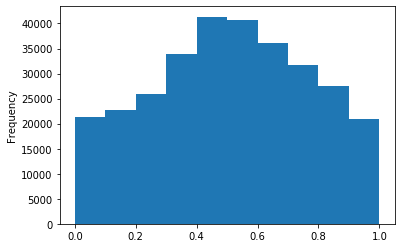

In [18]:
predictions.prediction.plot(kind='hist')